In [2]:
# import all necessary libraries
!pip install mysql-connector-python
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
#import tensorflow
#import keras
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import time
import json
import re
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pickle
from datetime import datetime
from datetime import timedelta
import requests
from requests.auth import AuthBase
import config
import tools
import mysql.connector
import urllib.parse
from mysql.connector import errorcode
import sqlite3
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

  Using cached protobuf-3.6.1-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (1.2 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.11.4
    Uninstalling protobuf-3.11.4:
      Successfully uninstalled protobuf-3.11.4


In [ ]:
# reload our tweets from pickle checkpoint
with open("AMZN_tweets_df.pkl", 'rb') as f:
    df1 = pickle.load(f)
df1

In [198]:
# read in pickle file from alphavantage api call
with open('tsla_alphavantage.pkl', 'rb') as f:
    tsla_data = pickle.load(f)
# create a new column containing average price, calculated as arithmetic average of open and close
tsla_data['avg_price'] = ((tsla_data['1. open'] + tsla_data['4. close'])/2.0)

In [199]:
tsla_data

,1. open,2. high,3. low,4. close,5. volume,avg_price
date,,,,,,
2020-05-11 09:31:00,790.510,793.7100,785.0000,792.2900,865798.0,791.40000
2020-05-11 09:32:00,792.505,795.7800,791.1900,795.7800,156857.0,794.14250
2020-05-11 09:33:00,795.620,798.8900,792.9800,797.5000,130287.0,796.56000
2020-05-11 09:34:00,797.600,798.8000,794.5000,796.1730,111929.0,796.88650
2020-05-11 09:35:00,796.150,797.4800,791.7950,791.9894,102842.0,794.06970
...,...,...,...,...,...,...
2020-05-15 15:56:00,800.830,800.9000,800.1800,800.2700,25768.0,800.55000
2020-05-15 15:57:00,800.255,800.5900,799.5212,800.0901,35831.0,800.17255
2020-05-15 15:58:00,800.160,800.3500,798.8385,799.2000,33430.0,799.68000


In [200]:
# capture tweet volume information
df1['tweet_count'] = [1 for i in range(len(df1.index))]
count_only = df1['tweet_count'].groupby('datetime').sum()
count_only

datetime
2020-05-11 09:01:00    1
2020-05-11 09:02:00    1
2020-05-11 09:04:00    1
2020-05-11 09:05:00    2
2020-05-11 09:06:00    1
                      ..
2020-05-15 22:35:00    4
2020-05-15 22:36:00    1
2020-05-15 22:38:00    2
2020-05-15 22:40:00    3
2020-05-15 22:41:00    2
Name: tweet_count, Length: 5562, dtype: int64

In [201]:
# discard all but the sentiment and volume information from our tweet dataframe
sent_only = df1.drop(columns=['tweet','id','price']).groupby('datetime').mean()
sent_only['tweet_count'] = count_only
sent_only

,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count
datetime,,,,,
2020-05-11 09:01:00,0.51060,0.10200,0.000000,0.898000,1
2020-05-11 09:02:00,0.42150,0.21900,0.000000,0.781000,1
2020-05-11 09:04:00,0.84360,0.34800,0.000000,0.652000,1
2020-05-11 09:05:00,-0.12500,0.03450,0.063000,0.902500,2
2020-05-11 09:06:00,-0.45880,0.00000,0.085000,0.915000,1
...,...,...,...,...,...
2020-05-15 22:35:00,-0.01055,0.04525,0.055500,0.899250,4
2020-05-15 22:36:00,0.90810,0.38300,0.000000,0.617000,1
2020-05-15 22:38:00,0.46170,0.13850,0.000000,0.861500,2


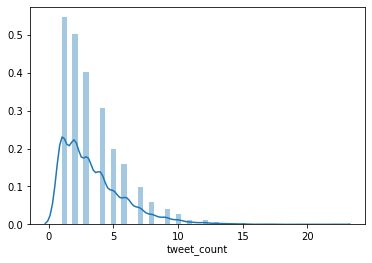

In [202]:
# quick visual of tweet volume distribution
sns.distplot(sent_only['tweet_count'])

In [203]:
# convert from UTC to EST, as twitter API defaults to UTC, but AlphaVantage defaults to EST
sent_only['eastern_time'] = sent_only.index - timedelta(hours = 4)
sent_only.set_index('eastern_time', drop=True, inplace=True)
sent_only

,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count
eastern_time,,,,,
2020-05-11 05:01:00,0.51060,0.10200,0.000000,0.898000,1
2020-05-11 05:02:00,0.42150,0.21900,0.000000,0.781000,1
2020-05-11 05:04:00,0.84360,0.34800,0.000000,0.652000,1
2020-05-11 05:05:00,-0.12500,0.03450,0.063000,0.902500,2
2020-05-11 05:06:00,-0.45880,0.00000,0.085000,0.915000,1
...,...,...,...,...,...
2020-05-15 18:35:00,-0.01055,0.04525,0.055500,0.899250,4
2020-05-15 18:36:00,0.90810,0.38300,0.000000,0.617000,1
2020-05-15 18:38:00,0.46170,0.13850,0.000000,0.861500,2


In [204]:
# chunk up our price dataframe into trading days
mon = tsla_data.loc['2020-05-11 09:31':'2020-05-11 16:00:00']
tues = tsla_data.loc['2020-05-12 09:31:00':'2020-05-12 16:00:00']
wed = tsla_data.loc['2020-05-13 09:31':'2020-05-13 16:00:00']
thur = tsla_data.loc['2020-05-14 09:31':'2020-05-14 16:00:00']
fri = tsla_data.loc['2020-05-15 09:31':'2020-05-15 16:00:00']

# add padding to the beginning of our price series so it aligns with our tweets
a = mon.index[0]
mins = int(60*4.5) + 1
timeList = []
for x in range (0, mins):
    timeList.append(a - timedelta(minutes = x))
timeList = timeList[1:]
time_adj_df1 = pd.DataFrame(timeList)
time_adj_df1['1. open'] = np.NaN
time_adj_df1['2. high'] = np.NaN
time_adj_df1['3. low'] = np.NaN
time_adj_df1['4. close'] = np.NaN
time_adj_df1['5. volume'] = np.NaN
time_adj_df1['avg_price'] = np.NaN
time_adj_df1 = time_adj_df1[::-1]
time_adj_df1['date'] = time_adj_df1[0]
time_adj_df1.set_index('date', drop=True, inplace=True)
time_adj_df1.drop(columns=[0], inplace=True)

# create datapoints for monday night so our data remains continuous
a = tues.index[0]
mins = int(60*17.5) + 1
timeList = []
for x in range (0, mins):
    timeList.append(a - timedelta(minutes = x))
timeList = timeList[1:]
mon_night = pd.DataFrame(timeList)
mon_night['1. open'] = np.NaN
mon_night['2. high'] = np.NaN
mon_night['3. low'] = np.NaN
mon_night['4. close'] = np.NaN
mon_night['5. volume'] = np.NaN
mon_night['avg_price'] = np.NaN
mon_night = mon_night[::-1]
mon_night['date'] = mon_night[0]
mon_night.set_index('date', drop=True, inplace=True)
mon_night.drop(columns=[0], inplace=True)

# create datapoints for tuesday night so our data remains continuous
a = wed.index[0]
mins = int(60*17.5) + 1
timeList = []
for x in range (0, mins):
    timeList.append(a - timedelta(minutes = x))
timeList = timeList[1:]
tues_night = pd.DataFrame(timeList)
tues_night['1. open'] = np.NaN
tues_night['2. high'] = np.NaN
tues_night['3. low'] = np.NaN
tues_night['4. close'] = np.NaN
tues_night['5. volume'] = np.NaN
tues_night['avg_price'] = np.NaN
tues_night = tues_night[::-1]
tues_night['date'] = tues_night[0]
tues_night.set_index('date', drop=True, inplace=True)
tues_night.drop(columns=[0], inplace=True)

# create datapoints for wednesday night so our data remains continuous
a = thur.index[0]
mins = int(60*17.5) + 1
timeList = []
for x in range (0, mins):
    timeList.append(a - timedelta(minutes = x))
timeList = timeList[1:]
wed_night = pd.DataFrame(timeList)
wed_night['1. open'] = np.NaN
wed_night['2. high'] = np.NaN
wed_night['3. low'] = np.NaN
wed_night['4. close'] = np.NaN
wed_night['5. volume'] = np.NaN
wed_night['avg_price'] = np.NaN
wed_night = wed_night[::-1]
wed_night['date'] = wed_night[0]
wed_night.set_index('date', drop=True, inplace=True)
wed_night.drop(columns=[0], inplace=True)

# create datapoints for thursday night so our data remains continuous
a = fri.index[0]
mins = int(60*17.5) + 1
timeList = []
for x in range (0, mins):
    timeList.append(a - timedelta(minutes = x))
timeList = timeList[1:]
thur_night = pd.DataFrame(timeList)
thur_night['1. open'] = np.NaN
thur_night['2. high'] = np.NaN
thur_night['3. low'] = np.NaN
thur_night['4. close'] = np.NaN
thur_night['5. volume'] = np.NaN
thur_night['avg_price'] = np.NaN
thur_night = thur_night[::-1]
thur_night['date'] = thur_night[0]
thur_night.set_index('date', drop=True, inplace=True)
thur_night.drop(columns=[0], inplace=True)

# fill in sporadically missing times
timeList = ['2020-05-13 11:35:00', '2020-05-13 11:41:00', '2020-05-13 11:44:00',
            '2020-05-13 11:12:00', '2020-05-13 11:13:00', '2020-05-13 11:14:00',
            '2020-05-13 11:15:00', '2020-05-13 11:16:00', '2020-05-13 11:35:00',
            '2020-05-14 09:58:00', '2020-05-14 09:59:00', '2020-05-14 10:00:00',
            '2020-05-14 12:39:00', '2020-05-14 12:40:00']
time_adj_df2 = pd.DataFrame(timeList)
time_adj_df2['1. open'] = np.NaN
time_adj_df2['2. high'] = np.NaN
time_adj_df2['3. low'] = np.NaN
time_adj_df2['4. close'] = np.NaN
time_adj_df2['5. volume'] = np.NaN
time_adj_df2['avg_price'] = np.NaN
time_adj_df2 = time_adj_df2[::-1]
time_adj_df2['date'] = time_adj_df2[0]
time_adj_df2.set_index('date', drop=True, inplace=True)
time_adj_df2.drop(columns=[0], inplace=True)

In [205]:
# concatenate our trading days, nights, and adjustment dataframes
dfs = [time_adj_df1, mon, mon_night, tues, tues_night, wed, wed_night, thur, thur_night, fri, time_adj_df2]
tsla_round_clock = pd.concat(dfs)

In [206]:
# ensure that all of our datetime stamps are actually datetimes, as some were merely strings
tsla_round_clock[0] = [pd.to_datetime(i) for i in tsla_round_clock.index]
tsla_round_clock.set_index(0, inplace=True)
tsla_round_clock.sort_values(0, inplace=True)
tsla_round_clock

,1. open,2. high,3. low,4. close,5. volume,avg_price
0,,,,,,
2020-05-11 05:01:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 05:02:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 05:03:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 05:04:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 05:05:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-05-15 15:56:00,800.830,800.9000,800.1800,800.2700,25768.0,800.55000
2020-05-15 15:57:00,800.255,800.5900,799.5212,800.0901,35831.0,800.17255
2020-05-15 15:58:00,800.160,800.3500,798.8385,799.2000,33430.0,799.68000


In [207]:
# integrate our tweet sentiment and volume information into our price series and volume dataframe
for row in tsla_round_clock.index:
    if row in sent_only.index:
        tsla_round_clock.loc[row, 'compound_sentiment'] = sent_only.loc[row, 'compound_sentiment']
        tsla_round_clock.loc[row, 'positive_sentiment'] = sent_only.loc[row, 'positive_sentiment']
        tsla_round_clock.loc[row, 'negative_sentiment'] = sent_only.loc[row, 'negative_sentiment']
        tsla_round_clock.loc[row, 'neutral_sentiment'] = sent_only.loc[row, 'neutral_sentiment']
        tsla_round_clock.loc[row, 'tweet_count'] = sent_only.loc[row, 'tweet_count']
    else:
        tsla_round_clock.loc[row, 'compound_sentiment'] = np.NaN
        tsla_round_clock.loc[row, 'positive_sentiment'] = np.NaN
        tsla_round_clock.loc[row, 'negative_sentiment'] = np.NaN
        tsla_round_clock.loc[row, 'neutral_sentiment'] = np.NaN
        tsla_round_clock.loc[row, 'tweet_count'] = 0
tsla_round_clock

,1. open,2. high,3. low,4. close,5. volume,avg_price,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count
0,,,,,,,,,,,
2020-05-11 05:01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.510600,0.102000,0.000000,0.898000,1.0
2020-05-11 05:02:00,NaN,NaN,NaN,NaN,NaN,NaN,0.421500,0.219000,0.000000,0.781000,1.0
2020-05-11 05:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-05-11 05:04:00,NaN,NaN,NaN,NaN,NaN,NaN,0.843600,0.348000,0.000000,0.652000,1.0
2020-05-11 05:05:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.125000,0.034500,0.063000,0.902500,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-15 15:56:00,800.830,800.9000,800.1800,800.2700,25768.0,800.55000,0.122817,0.089333,0.034333,0.876333,6.0
2020-05-15 15:57:00,800.255,800.5900,799.5212,800.0901,35831.0,800.17255,0.178267,0.065000,0.000000,0.935000,3.0
2020-05-15 15:58:00,800.160,800.3500,798.8385,799.2000,33430.0,799.68000,-0.324300,0.000000,0.162500,0.837500,2.0


In [208]:
# another checkpoint
with open('tsla_round_clock.pkl', 'wb') as f:
    pickle.dump(tsla_round_clock, f)

In [209]:
# reload from checkpoint
with open('tsla_round_clock.pkl', 'rb') as f:
    tsla_round_clock = pickle.load(f)

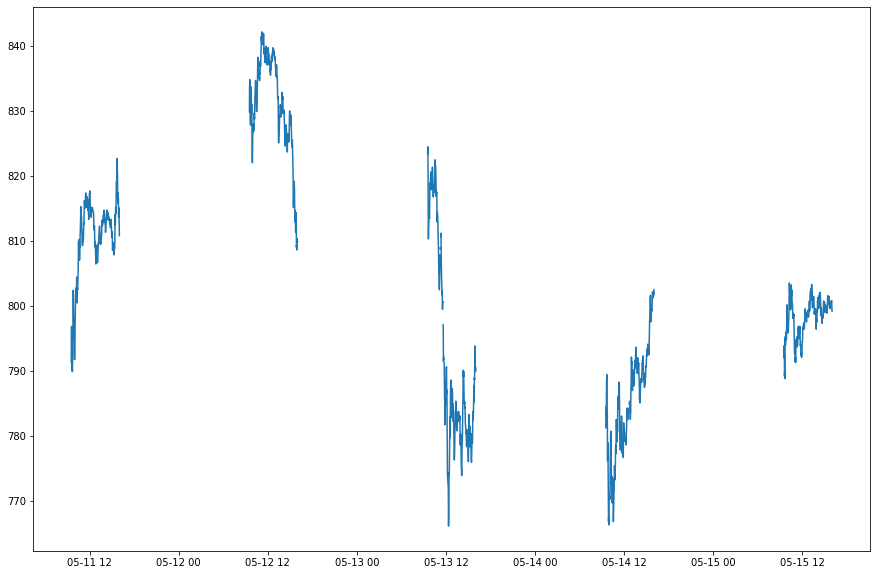

In [210]:
# visual of our current price series, clearly discontinuous overnight and mid-day on wednesday
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(tsla_round_clock.index, tsla_round_clock.avg_price)

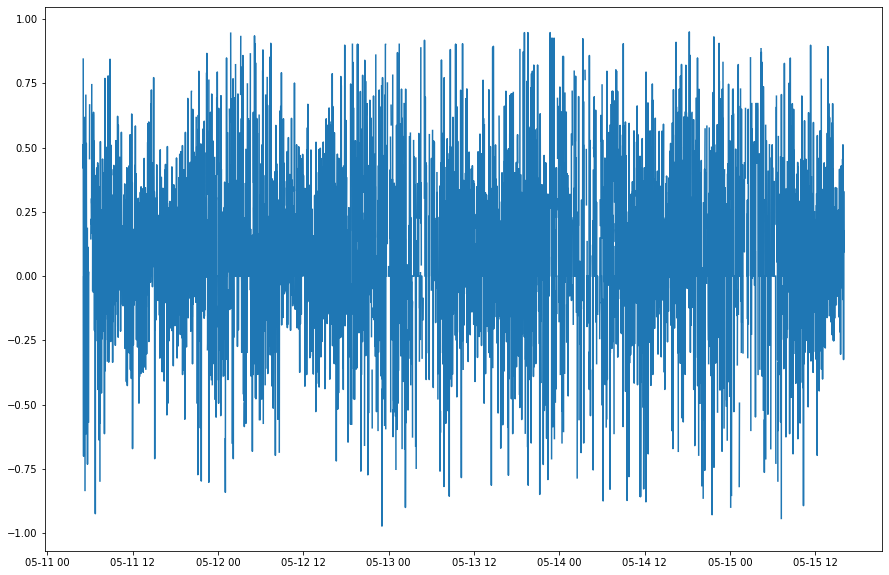

In [211]:
# visual of compound sentiment time series
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(tsla_round_clock.index, tsla_round_clock.compound_sentiment)

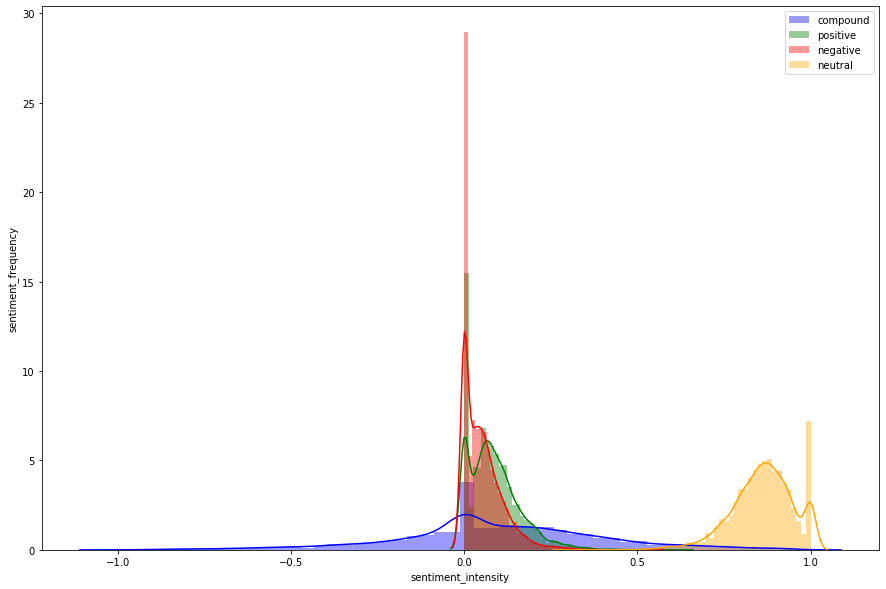

In [212]:
# frequency distribution of various types of sentiments captured
fig, ax = plt.subplots(1, figsize=(15,10), sharex=True)
sns.distplot(tsla_round_clock.compound_sentiment, color='blue', label='compound', ax=ax)
sns.distplot(tsla_round_clock.positive_sentiment, color='green', label='positive', ax=ax)
sns.distplot(tsla_round_clock.negative_sentiment, color='red', label='negative', ax=ax)
sns.distplot(tsla_round_clock.neutral_sentiment, color = 'orange', label='neutral', ax=ax)
ax.set_xlabel('sentiment_intensity')
ax.set_ylabel('sentiment_frequency')
plt.legend()

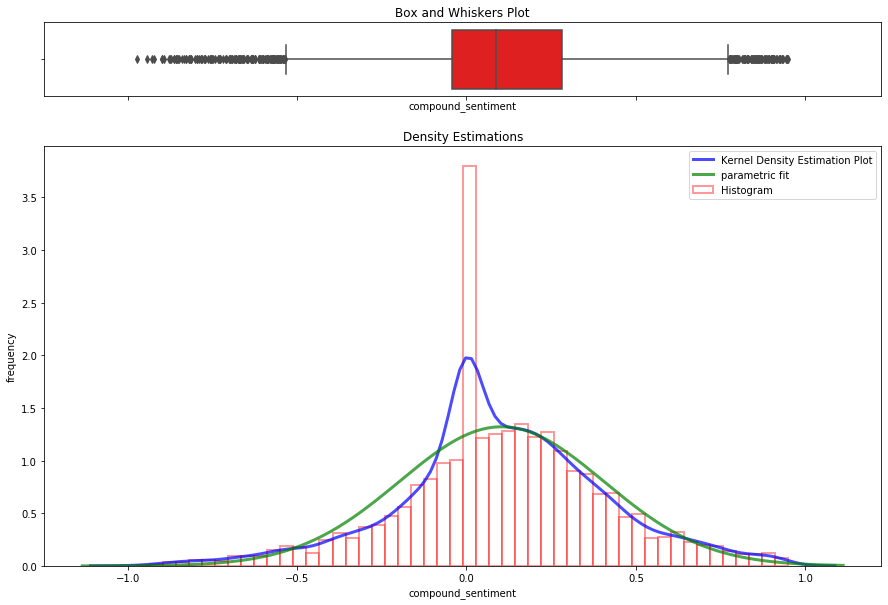

In [213]:
# more detailed visualization of compound sentiment, which we will most likely use in our final analysis
fig, (ax, ax2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (15,10))

sns.distplot(tsla_round_clock.compound_sentiment, 
             hist=True, hist_kws={
                                  "linewidth": 2,
                                  "edgecolor" :'red',
                                  "alpha": 0.4, 
                                  "color":  "w",
                                  "label": "Histogram",
                                  },
             kde=True, kde_kws = {'linewidth': 3,
                                  'color': "blue",
                                  "alpha": 0.7,
                                  'label':'Kernel Density Estimation Plot'
                                 },
             fit= sp.stats.norm, fit_kws = {'color' : 'green',
                                         'label' : 'parametric fit',
                                         "alpha": 0.7,
                                          'linewidth':3},
             ax=ax2)
ax2.set_title('Density Estimations')
ax2.set_ylabel('frequency')
sns.boxplot(x=tsla_round_clock.compound_sentiment, ax = ax,color = 'red')
ax.set_title('Box and Whiskers Plot')
#ax2.set(ylim=(0, .08))
#plt.ylim(0,0.11)
plt.legend();

In [214]:
# another pickle checkpoint
with open('tsla_round_clock.pkl', 'wb') as f:
    pickle.dump(tsla_round_clock, f)

In [216]:
# reload from pickle checkpoint
with open('tsla_round_clock.pkl', 'rb') as f:
    tsla_round_clock = pickle.load(f)
tsla_round_clock

,1. open,2. high,3. low,4. close,5. volume,avg_price,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count
0,,,,,,,,,,,
2020-05-11 05:01:00,NaN,NaN,NaN,NaN,NaN,NaN,0.510600,0.102000,0.000000,0.898000,1.0
2020-05-11 05:02:00,NaN,NaN,NaN,NaN,NaN,NaN,0.421500,0.219000,0.000000,0.781000,1.0
2020-05-11 05:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-05-11 05:04:00,NaN,NaN,NaN,NaN,NaN,NaN,0.843600,0.348000,0.000000,0.652000,1.0
2020-05-11 05:05:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.125000,0.034500,0.063000,0.902500,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-15 15:56:00,800.830,800.9000,800.1800,800.2700,25768.0,800.55000,0.122817,0.089333,0.034333,0.876333,6.0
2020-05-15 15:57:00,800.255,800.5900,799.5212,800.0901,35831.0,800.17255,0.178267,0.065000,0.000000,0.935000,3.0
2020-05-15 15:58:00,800.160,800.3500,798.8385,799.2000,33430.0,799.68000,-0.324300,0.000000,0.162500,0.837500,2.0


In [219]:
# fill NaN values with last valid value
tsla_round_clock1 = tsla_round_clock.fillna(method='ffill')
tsla_round_clock1['trade_volume'] = tsla_round_clock['5. volume'].fillna(0)
tsla_round_clock1['avg_price'].fillna(819.42, inplace=True)
# drop superfluous columns
tsla_round_clock1.drop(columns=['1. open','2. high','3. low','4. close', '5. volume'], inplace=True)
tsla_round_clock = tsla_round_clock1
tsla_round_clock

,avg_price,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count,trade_volume
0,,,,,,,
2020-05-11 05:01:00,819.42000,0.510600,0.102000,0.000000,0.898000,1.0,0.0
2020-05-11 05:02:00,819.42000,0.421500,0.219000,0.000000,0.781000,1.0,0.0
2020-05-11 05:03:00,819.42000,0.421500,0.219000,0.000000,0.781000,0.0,0.0
2020-05-11 05:04:00,819.42000,0.843600,0.348000,0.000000,0.652000,1.0,0.0
2020-05-11 05:05:00,819.42000,-0.125000,0.034500,0.063000,0.902500,2.0,0.0
...,...,...,...,...,...,...,...
2020-05-15 15:56:00,800.55000,0.122817,0.089333,0.034333,0.876333,6.0,25768.0
2020-05-15 15:57:00,800.17255,0.178267,0.065000,0.000000,0.935000,3.0,35831.0
2020-05-15 15:58:00,799.68000,-0.324300,0.000000,0.162500,0.837500,2.0,33430.0


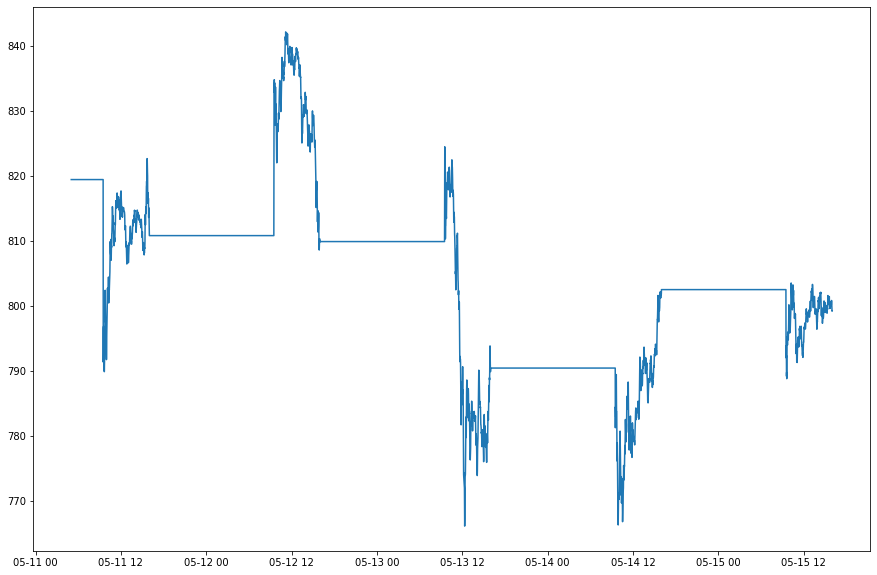

In [220]:
# visualization of our completed price series
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(tsla_round_clock.index, tsla_round_clock.avg_price)

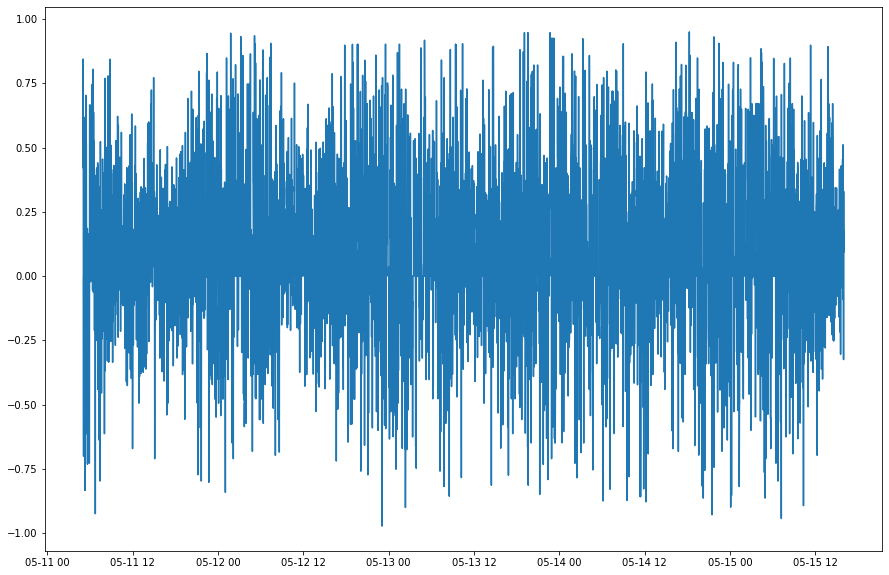

In [221]:
# visualization of our continuous compound sentiment series
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(tsla_round_clock.index, tsla_round_clock.compound_sentiment)

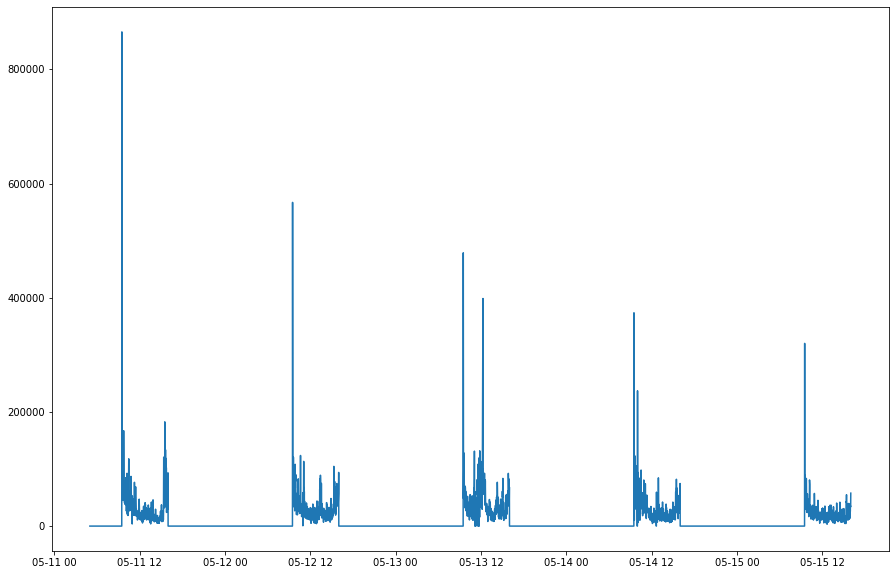

In [222]:
# visualization of our continuous trade volume series
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(tsla_round_clock.index, tsla_round_clock['trade_volume'])

In [223]:
# another pickle checkpoint
with open('tsla_round_clock.pkl', 'wb') as f:
    pickle.dump(tsla_round_clock, f)

In [7]:
# reload from pickle checkpoint
with open('tsla_round_clock.pkl', 'rb') as f:
    tsla_round_clock = pickle.load(f)
tsla_round_clock

,avg_price,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count,trade_volume
0,,,,,,,
2020-05-11 05:01:00,819.42000,0.510600,0.102000,0.000000,0.898000,1.0,0.0
2020-05-11 05:02:00,819.42000,0.421500,0.219000,0.000000,0.781000,1.0,0.0
2020-05-11 05:03:00,819.42000,0.421500,0.219000,0.000000,0.781000,0.0,0.0
2020-05-11 05:04:00,819.42000,0.843600,0.348000,0.000000,0.652000,1.0,0.0
2020-05-11 05:05:00,819.42000,-0.125000,0.034500,0.063000,0.902500,2.0,0.0
...,...,...,...,...,...,...,...
2020-05-15 15:56:00,800.55000,0.122817,0.089333,0.034333,0.876333,6.0,25768.0
2020-05-15 15:57:00,800.17255,0.178267,0.065000,0.000000,0.935000,3.0,35831.0
2020-05-15 15:58:00,799.68000,-0.324300,0.000000,0.162500,0.837500,2.0,33430.0


In [8]:
data = tsla_round_clock.drop(columns=['positive_sentiment', 'negative_sentiment', 'neutral_sentiment'])
data.head(1000)

,avg_price,compound_sentiment,tweet_count,trade_volume
0,,,,
2020-05-11 05:01:00,819.42000,0.510600,1.0,0.0
2020-05-11 05:02:00,819.42000,0.421500,1.0,0.0
2020-05-11 05:03:00,819.42000,0.421500,0.0,0.0
2020-05-11 05:04:00,819.42000,0.843600,1.0,0.0
2020-05-11 05:05:00,819.42000,-0.125000,2.0,0.0
2020-05-11 05:06:00,819.42000,-0.458800,1.0,0.0
2020-05-11 05:07:00,819.42000,-0.699700,1.0,0.0
2020-05-11 05:08:00,819.42000,0.000000,1.0,0.0
2020-05-11 05:09:00,819.42000,-0.661500,1.0,0.0


In [33]:
reframed = tools.series_to_supervised(data, n_hours, 1)
reframed

var1(t-270)  var2(t-270)  var3(t-270)  var4(t-270)  \
0                                                                         
2020-05-11 09:31:00    819.42000      0.51060          1.0          0.0   
2020-05-11 09:32:00    819.42000      0.42150          1.0          0.0   
2020-05-11 09:33:00    819.42000      0.42150          0.0          0.0   
2020-05-11 09:34:00    819.42000      0.84360          1.0          0.0   
2020-05-11 09:35:00    819.42000     -0.12500          2.0          0.0   
...                          ...          ...          ...          ...   
2020-05-15 15:56:00    796.71500     -0.04340          3.0      25060.0   
2020-05-15 15:57:00    796.88535      0.38585          2.0      25519.0   
2020-05-15 15:58:00    796.37095      0.38585          0.0      26716.0   
2020-05-15 15:59:00    796.51080     -0.01712          5.0      13362.0   
2020-05-15 16:00:00    795.33500     -0.01712          0.0      23777.0   

                     var1(t-269)  var2(t-269)  var3(t-269)  var4(t-269)  \
0                                                                         
2020-05-11 09:31:00    819.42000      0.42150          1.0          0.0   
2020-05-11 09:32:00    819.42000      0.42150          0.0          0.0   
2020-05-11 09:33:00    819.42000      0.84360          1.0          0.0   
2020-05-11 09:34:00    819.42000     -0.12500          2.0          0.0   
2020-05-11 09:35:00    819.42000     -0.45880          1.0          0.0   
...                          ...          ...          ...          ...   
2020-05-15 15:56:00    796.88535      0.38585          2.0      25519.0   
2020-05-15 15:57:00    796.37095      0.38585          0.0      26716.0   
2020-05-15 15:58:00    796.51080     -0.01712          5.0      13362.0   
2020-05-15 15:59:00    795.33500     -0.01712          0.0      23777.0   
2020-05-15 16:00:00    795.04500     -0.13046          5.0      16240.0   

                     var1(t-268)  var2(t-268)  var3(t-268)  var4(t-268)  \
0                                                                         
2020-05-11 09:31:00    819.42000      0.42150          0.0          0.0   
2020-05-11 09:32:00    819.42000      0.84360          1.0          0.0   
2020-05-11 09:33:00    819.42000     -0.12500          2.0          0.0   
2020-05-11 09:34:00    819.42000     -0.45880          1.0          0.0   
2020-05-11 09:35:00    819.42000     -0.69970          1.0          0.0   
...                          ...          ...          ...          ...   
2020-05-15 15:56:00    796.37095      0.38585          0.0      26716.0   
2020-05-15 15:57:00    796.51080     -0.01712          5.0      13362.0   
2020-05-15 15:58:00    795.33500     -0.01712          0.0      23777.0   
2020-05-15 15:59:00    795.04500     -0.13046          5.0      16240.0   
2020-05-15 16:00:00    794.98365     -0.15808          5.0      18587.0   

                     var1(t-267)  var2(t-267)  var3(t-267)  var4(t-267)  \
0                                                                         
2020-05-11 09:31:00    819.42000     0.843600          1.0          0.0   
2020-05-11 09:32:00    819.42000    -0.125000          2.0          0.0   
2020-05-11 09:33:00    819.42000    -0.458800          1.0          0.0   
2020-05-11 09:34:00    819.42000    -0.699700          1.0          0.0   
2020-05-11 09:35:00    819.42000     0.000000          1.0          0.0   
...                          ...          ...          ...          ...   
2020-05-15 15:56:00    796.51080    -0.017120          5.0      13362.0   
2020-05-15 15:57:00    795.33500    -0.017120          0.0      23777.0   
2020-05-15 15:58:00    795.04500    -0.130460          5.0      16240.0   
2020-05-15 15:59:00    794.98365    -0.158080          5.0      18587.0   
2020-05-15 16:00:00    795.57500    -0.113333          3.0      22441.0   

                     var1(t-266)  var2(t-266)  var3(t-266)  var4(t-266)  \
0                                         

In [46]:
data.values

array([[ 8.1942000e+02,  5.1060000e-01,  1.0000000e+00,  0.0000000e+00],
       [ 8.1942000e+02,  4.2150000e-01,  1.0000000e+00,  0.0000000e+00],
       [ 8.1942000e+02,  4.2150000e-01,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 7.9968000e+02, -3.2430000e-01,  2.0000000e+00,  3.3430000e+04],
       [ 7.9920750e+02,  3.2940000e-01,  2.0000000e+00,  3.5047000e+04],
       [ 7.9926945e+02,  9.4320000e-02,  5.0000000e+00,  5.7724000e+04]])

In [42]:
# load dataset
values = data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 270
n_features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, n_hours, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

     var1(t-270)  var2(t-270)  var3(t-270)  var4(t-270)  var1(t-269)  \
270     0.701208     0.771606     0.045455          0.0     0.701208   
271     0.701208     0.725219     0.045455          0.0     0.701208   
272     0.701208     0.725219     0.000000          0.0     0.701208   
273     0.701208     0.944971     0.045455          0.0     0.701208   
274     0.701208     0.440702     0.090909          0.0     0.701208   

     var2(t-269)  var3(t-269)  var4(t-269)  var1(t-268)  var2(t-268)  \
270     0.725219     0.045455          0.0     0.701208     0.725219   
271     0.725219     0.000000          0.0     0.701208     0.944971   
272     0.944971     0.045455          0.0     0.701208     0.440702   
273     0.440702     0.090909          0.0     0.701208     0.266920   
274     0.266920     0.045455          0.0     0.701208     0.141504   

     var3(t-268)  var4(t-268)  var1(t-267)  var2(t-267)  var3(t-267)  \
270     0.000000          0.0     0.701208     0.944971     0.

In [35]:
# split into train and test sets
values = reframed.values
n_train_hours = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)


Train on 3540 samples, validate on 2610 samples
Epoch 1/20
3540/3540 - 86s - loss: 0.0213 - val_loss: 0.0130
Epoch 2/20
3540/3540 - 82s - loss: 0.0075 - val_loss: 0.0078
Epoch 3/20
3540/3540 - 82s - loss: 0.0060 - val_loss: 0.0048
Epoch 4/20
3540/3540 - 83s - loss: 0.0047 - val_loss: 0.0031
Epoch 5/20
3540/3540 - 83s - loss: 0.0036 - val_loss: 0.0021
Epoch 6/20
3540/3540 - 82s - loss: 0.0028 - val_loss: 0.0015
Epoch 7/20
3540/3540 - 82s - loss: 0.0023 - val_loss: 0.0011
Epoch 8/20
3540/3540 - 88s - loss: 0.0020 - val_loss: 8.8428e-04
Epoch 9/20
3540/3540 - 83s - loss: 0.0018 - val_loss: 7.5606e-04
Epoch 10/20
3540/3540 - 82s - loss: 0.0017 - val_loss: 6.7805e-04
Epoch 11/20
3540/3540 - 82s - loss: 0.0016 - val_loss: 6.2802e-04
Epoch 12/20
3540/3540 - 83s - loss: 0.0015 - val_loss: 5.9446e-04
Epoch 13/20
3540/3540 - 82s - loss: 0.0015 - val_loss: 5.7134e-04
Epoch 14/20
3540/3540 - 82s - loss: 0.0015 - val_loss: 5.5547e-04
Epoch 15/20
3540/3540 - 82s - loss: 0.0014 - val_loss: 5.4509e-04

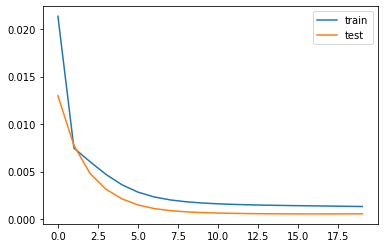

In [36]:
# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [37]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 1.776
Test MAE: 1.296


In [38]:
rmse/inv_y.std()

0.23981078757602656

In [60]:
def calc_rmse(y_test, y_pred):
    return (sum([(y_test[i] - y_pred[i])**2 for i in range(len(y_test))])/len(y_test))**(1/2)
def calc_mae(y_test, y_pred):
    return (sum([abs(y_test[i] - y_pred[i]) for i in range(len(y_test))])/len(y_test))

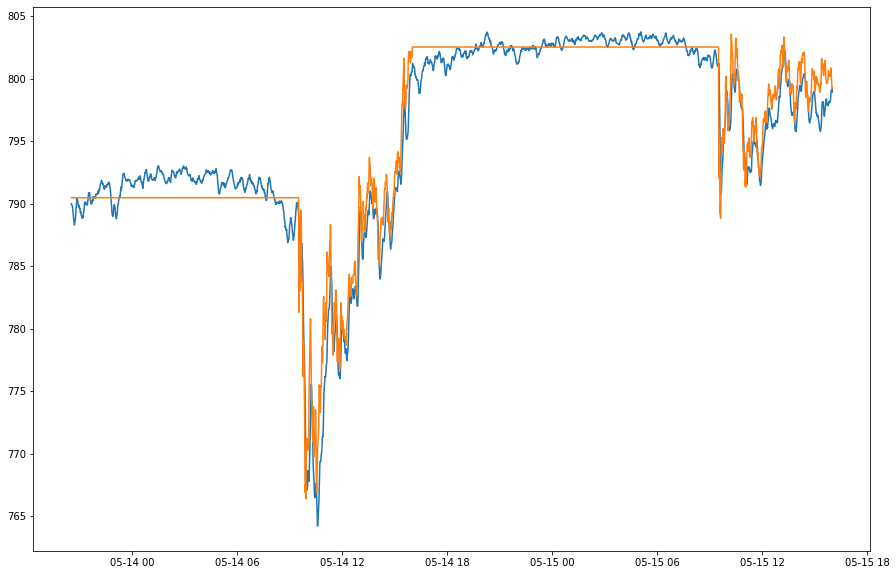

In [40]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], inv_yhat)
plt.plot(data.index[-2610:], data.avg_price[-2610:])

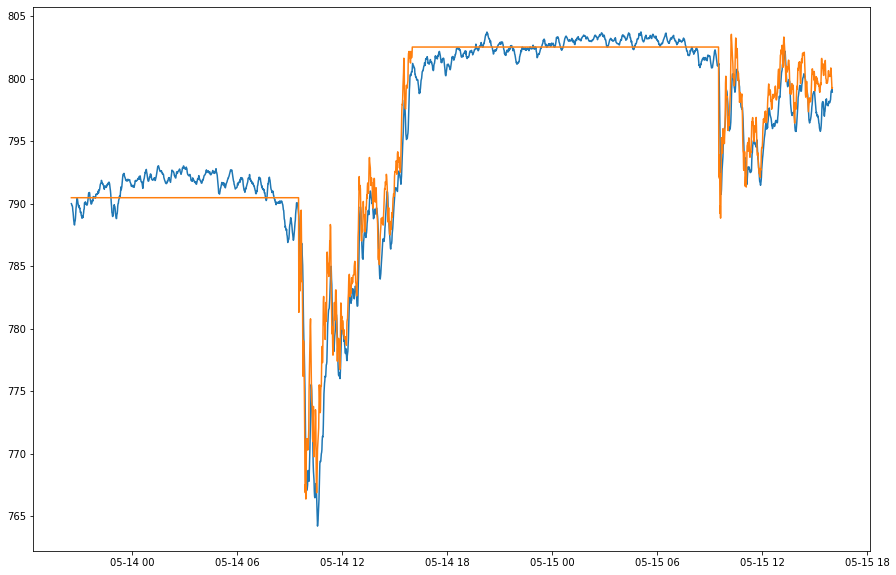

In [41]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], inv_yhat)
plt.plot(data.index[-2610:], inv_y)